# Letter Detection with an CNN


Using emnist/letters we first want to be able to detect letters before we move on to words.

In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Dense, Conv2D, AveragePooling2D, TimeDistributed, LSTM, GlobalAvgPool2D, AbstractRNNCell, MaxPooling2D
from keras.initializers import Orthogonal
import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm
import datetime


In [38]:
%load_ext tensorboard

In [23]:

def load_data():
    train_ds, test_ds = tfds.load('emnist/letters', split=['train', 'test'], as_supervised=True, with_info=True)
    
    print(train_ds)
    return train_ds, test_ds



In [34]:

def preprocess(ds, batch_size=32):
    ds = ds.map(lambda image,label: ((tf.cast(image, tf.float32)/128. -1), tf.one_hot(label, 26)))
    #ds = ds.map(lambda image,label: (tf.transpose(image), label))
    ds.cache()    
    ds = ds.shuffle(2000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds


In [25]:
# Check Dataset Information
(train_ds,test_ds), ds_info = load_data()

[<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, <PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]


[<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, <PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]


2022-12-30 11:51:13.326699: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


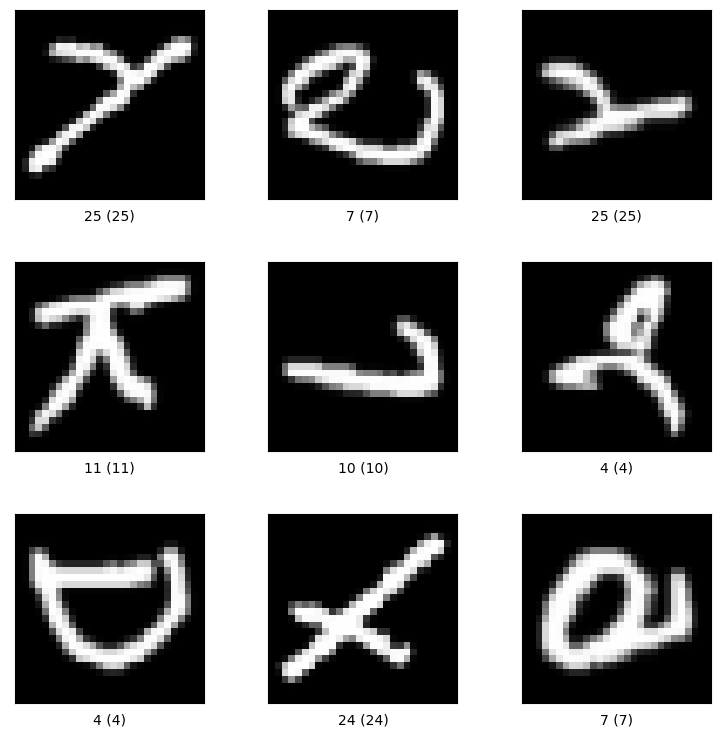

In [26]:
def show_examples(train_ds, ds_info):
    tfds.show_examples(train_ds, ds_info)

(train_ds,test_ds), ds_info = load_data()
show_examples(train_ds, ds_info)

In [36]:
class CNN(tf.keras.Model):
    def __init__(self, optimizer, loss_function, input_shape) -> None:
        super().__init__()
        # input conv1 = 28x28x1
        self.conv1 = Conv2D(24, 3, activation='relu', padding='valid')
        # output conv1 = 28x28x24
        self.conv2 = Conv2D(24, 3, activation='relu', padding='valid')
        # output conv2 = 28x28x24
        self.pooling1 = MaxPooling2D()
        # output pooling1 = 14x14x24
        self.conv3 = Conv2D(24, 3, activation='relu', padding='valid')
        # output conv3 = 14x14x24
        self.conv4 = Conv2D(24, 3, activation='relu', padding='valid')
        # output conv3 = 14x14x24
        self.globalpooling = GlobalAvgPool2D()
        # output globalpooling = 7x7x24
        self.out = Dense(26, activation="softmax")

        self.optimizer = optimizer
        self.loss_function = loss_function

        self.metrics_list = [
                tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                tf.keras.metrics.Mean(name="loss")
            ]

    @tf.function
    def __call__(self, x, training=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pooling1(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.globalpooling(x)
        x = self.out(x)
        return x


    # RESET ALL METRICS
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    def train_step(self, data):
        image, label = data

        with tf.GradientTape() as tape:
            prediction = self(image, training = True)
            loss = self.loss_function(label, prediction)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
        self.metrics[0].update_state(label, prediction)
        self.metrics[1].update_state(loss)


    def test_step(self, data):
        image, label = data
        prediction = self(image, training = False)
        loss = self.loss_function(label, prediction)
        self.metrics[0].update_state(label, prediction)
        self.metrics[1].update_state(loss)


In [28]:
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range (epochs):
        model.reset_metrics()
        for data in tqdm(train_ds,position=0,leave=True):
            model.train_step(data)

        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
        print("Epoch: ", epoch)
        print("Loss: ", model.metrics[1].result().numpy(), "Accuracy: ", model.metrics[0].result().numpy(), "(Train)")
        model.reset_metrics()

        for data in test_ds:
            model.test_step(data)

        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)

        print("Loss: ", model.metrics[1].result().numpy(), "Accuracy: ", model.metrics[0].result().numpy(), "(Test)")
    model.save_weights(save_path)




In [37]:
(train_ds,test_ds), ds_info = load_data()
print("successfully loaded data")
train_ds = preprocess(train_ds)
test_ds = preprocess(test_ds)


optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
cnn = CNN(optimizer=optimizer, loss_function=loss_function, input_shape=(28,28,1))
epochs = 10

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{optimizer}/{current_time}"
train_log_path = f"logs/{current_time}/train"
test_log_path = f"logs/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop(cnn, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)


[<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, <PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]
successfully loaded data


100%|██████████| 2775/2775 [00:28<00:00, 98.13it/s] 


Epoch:  0
Loss:  1.2336192 Accuracy:  0.5910022 (Train)
Loss:  0.75488544 Accuracy:  0.7678378 (Test)


100%|██████████| 2775/2775 [00:28<00:00, 98.73it/s] 


Epoch:  1
Loss:  0.53466326 Accuracy:  0.79513514 (Train)
Loss:  0.5073698 Accuracy:  0.83493245 (Test)


100%|██████████| 2775/2775 [00:27<00:00, 99.41it/s] 


Epoch:  2
Loss:  0.399207 Accuracy:  0.83431304 (Train)
Loss:  0.40201634 Accuracy:  0.8714865 (Test)


100%|██████████| 2775/2775 [00:27<00:00, 100.80it/s]


Epoch:  3
Loss:  0.336044 Accuracy:  0.85323197 (Train)
Loss:  0.367512 Accuracy:  0.88222975 (Test)


100%|██████████| 2775/2775 [00:27<00:00, 101.32it/s]


Epoch:  4
Loss:  0.29883346 Accuracy:  0.8655743 (Train)
Loss:  0.32859403 Accuracy:  0.8941892 (Test)


100%|██████████| 2775/2775 [00:28<00:00, 98.88it/s] 


Epoch:  5
Loss:  0.27337188 Accuracy:  0.87287164 (Train)
Loss:  0.30409208 Accuracy:  0.902027 (Test)


100%|██████████| 2775/2775 [00:27<00:00, 100.54it/s]


Epoch:  6
Loss:  0.25509372 Accuracy:  0.87804055 (Train)
Loss:  0.3013271 Accuracy:  0.9012162 (Test)


100%|██████████| 2775/2775 [00:27<00:00, 100.15it/s]


Epoch:  7
Loss:  0.24044871 Accuracy:  0.8832995 (Train)
Loss:  0.2829788 Accuracy:  0.90743244 (Test)


100%|██████████| 2775/2775 [00:27<00:00, 100.27it/s]


Epoch:  8
Loss:  0.23018488 Accuracy:  0.88596845 (Train)
Loss:  0.2795601 Accuracy:  0.90344596 (Test)


100%|██████████| 2775/2775 [00:28<00:00, 98.13it/s] 


Epoch:  9
Loss:  0.22153355 Accuracy:  0.88875 (Train)
Loss:  0.27564248 Accuracy:  0.9089865 (Test)


In [39]:
%tensorboard --logdir logs/